# Lesson 2: Practical Deep Learning for Coders - Deployment

This notebook presents my personal notes and work coming from my experience with the second lesson of the course "**Practical Deep Learning**" by Jeremy Howard ([here](https://www.youtube.com/watch?v=F4tvM4Vb3A0&t=18s) for the video on YT) and the related fastbook, the Jupyter-Book from fast.ai. The lecture is based on the second chapter of the book. 

The lesson presents key concepts, guiding the transformation of our model prototype from Lesson 1 into an end-to-end deep learning system for deployment in a production environment.

Lesson structure:
- Recap and clarifications;
- Bear Classifier: Data cleaning and augmentation;
- Turning Your Model into an Online Application on HF Space with.Gradio;

In [1]:
# Uncomment to install the necessary packages  
# !pip install -r requirements.txt

In [2]:
# Comment to get warnings
import warnings
warnings.filterwarnings('ignore')

## Recap and clarifications

Frome lesson 1, we have seen how deep learning can solve complex problems with minimal code, especially for beginners dealing with similar example problems. However, it's not a one-size-fits-all solution. Underestimating its constraints or overestimating its capabilities can lead to frustrating results. It's crucial to keep an open mind, exploring the potential benefits while being aware of limitations. By gradually implementing and backtesting models, you can manage risks and discover the specific capabilities and constraints relevant to your problem.

Hence, how to approach deep learning?

The course advice you to start your deep learning journey by **working on a project**. Choose something with readily available data to avoid wasting time searching for the perfect dataset. Iterate through the project end-to-end, completing each step reasonably well in a timely manner. Practice and fail to develop an intuition for training models. If possible, start a project related to your existing work to leverage available data. Be creative and compromise if necessary, exploring similar projects to understand the overall process. As a beginner, avoid venturing into vastly different areas where deep learning hasn't been applied before to ensure clarity in problem-solving. Understanding the current state of deep learning capabilities will guide your project selection.

To ensure the practical utility of your models, consider the **Drivetrain Approach**, a systematic design method.

<div style="text-align:center">
<img src="./images/drivetrain.png" width="600" height="400">
</div>

Projects should start by defining clear objectives and identify actions (levers) to achieve it. After that, you shold determine the data needed for these actions before building predictive models. 

## Bear Classifier: Data cleaning and augmentation

For many types of projects, we are able to find all the data we need online. In this lesson we are trying to implement is a bear detector. It will discriminate between three types of bear: grizzly, black, and teddy bears. There are many images on the internet of each type of bear that we can use. We just need a way to find them and download them. As done in the first lesson, we are going to use duckduckgo as image-search engine. The book use Bing, but you need a registration key.

To refine and enhance a model for robustness and deployment, additional steps are crucial in the process. Two processes that significantly improve model performance are data cleaning and data augmentation. We will delve into these concepts as we download images.

### Download images

Let's download data for our bear recognizer as don in the previous lesson.

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import L

def search_images(term, max_images=30):
    # Define a function to download from ddg a max of max_images with the keyword term
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('grizzly bear', max_images=1)
urls[0]

Searching for 'grizzly bear'


'http://2.bp.blogspot.com/-NjMTuklENdE/UHzVv_8dIxI/AAAAAAAAA-U/tNBsQDn8kFI/s1600/Grizzly+Bear+Pic.jpg'

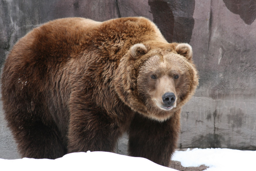

In [5]:
# download the image and save it in the dest provided
from fastdownload import download_url
dest = r'.\images\grizzly_bear.jpg'
download_url(urls[0], dest, show_progress=False)

# load the image in the Image object from fastai.vision and show it
from fastai.vision.all import Image
im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
from time import sleep
from pathlib import Path
from fastai.vision.all import download_images, resize_images
searches = 'grizzly','black','teddy'
path = Path('bear')

for o in []:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} bear',  max_images=300))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
from fastai.vision.all import verify_images, get_image_files
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

**Remark**: One thing to be aware of in this process, models can only reflect the data used to train them. And the world is full of **biased data**, which ends up reflected in, for example, duckduckgo (which we used to create our dataset). For instance, let's say you were interested in creating an app that could help users figure out whether they had healthy skin, so you trained a model on the results of searches for (say) "healthy skin."

<div style="text-align:center">
<img src="./images/healthy_skin.PNG" width="600" height="400">
</div>

With this as your training data, you would end up not with a healthy skin detector, but a young white woman touching her face detector! Be sure to think carefully about the types of data that you might expect to see in practice in your application, and check carefully to ensure that all these types are reflected in your model's source data.s)

**Remark**: You may expect data cleaning at this point, but actually, we are going to clean the data using a trained model! It could be surprising to you, but this approach could save time for you!

### Data Augmentation

We have seen how to define a DataBlock to handle the data loading during the training. 

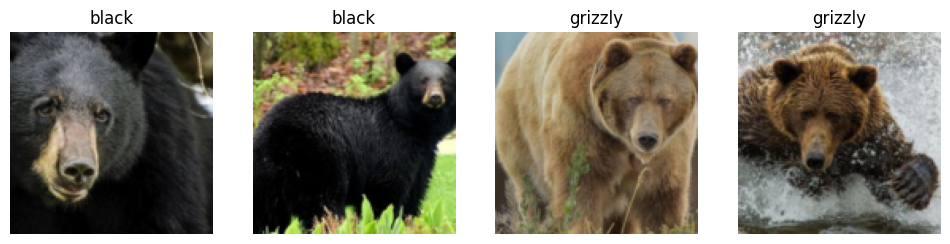

In [8]:
from fastai.vision.all import DataBlock, ImageBlock, CategoryBlock, RandomSplitter, parent_label, Resize
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

By default `Resize` crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them

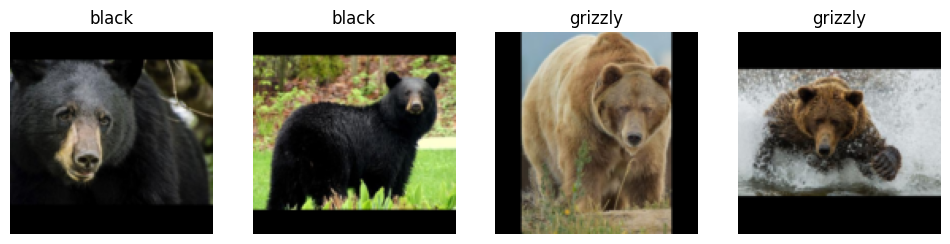

In [9]:
from fastai.vision.all import ResizeMethod
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Common image manipulations like squishing, cropping, or padding can be problematic for model accuracy. Squishing lead to unrealistic shapes, while cropping may remove crucial recognition features, and padding results in wasted computation. 

Instead, a practical approach is to **randomly select and crop** parts of the image during each epoch, allowing the model to focus on different features and mimic real-world variations in framing. This technique helps an untrained neural network understand basic concepts of object recognition, including variations in position and size.

Here's another example where we replace `Resize` with `RandomResizedCrop`, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

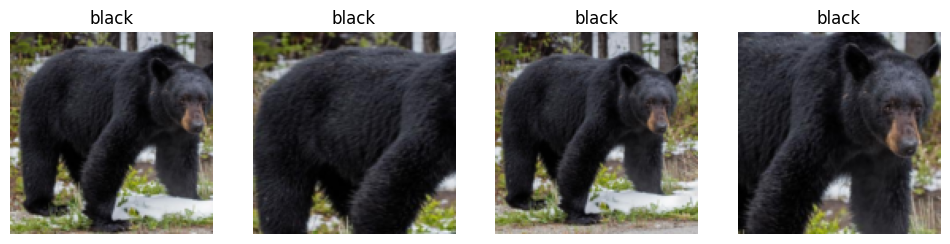

In [10]:
from fastai.vision.all import RandomResizedCrop
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

We used `unique=True` to have the same image repeated with different versions of this `RandomResizedCrop` transform. This is a specific example of a more general technique, called data augmentation.

A random resized crop is an example of data-augmentation.

More generally, data-augmentation involves creating random variations in input data without changing its meaning. Common techniques for image data include rotation, flipping, perspective warping, brightness, and contrast adjustments. In our case, we use the `aug_transforms` function for effective augmentations on a batch of images of the same size, optimizing GPU processing. To apply these transforms to a batch in fastai, we use the `batch_tfms` parameter, excluding `RandomResizedCrop` for clarity and doubling the default augmentation for better illustration.

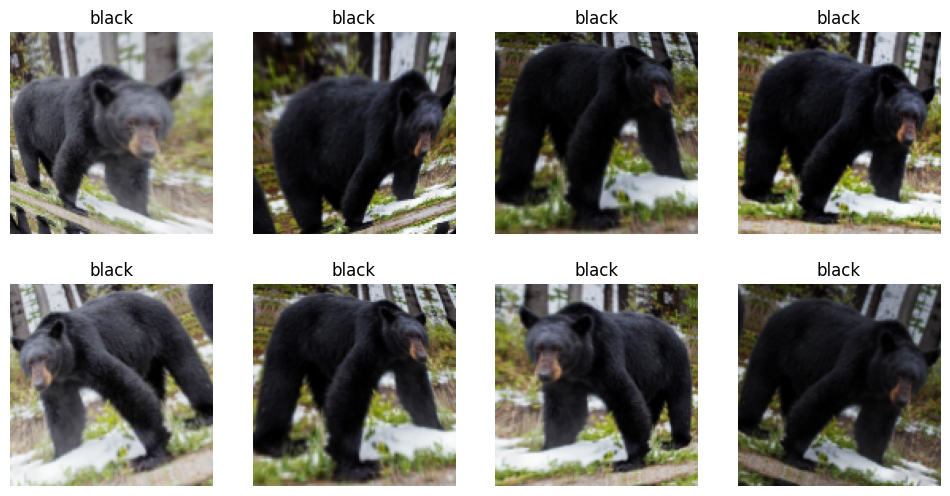

In [11]:
from fastai.vision.all import aug_transforms
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now that we have assembled our data in a format fit for model training, let's actually train an image classifier using it.

### Training Your Model, and Using It to Clean Your Data

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

In [12]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

We can now create our Learner and fine-tune it in the usual way:

In [13]:
from fastai.vision.all import vision_learner, resnet18, error_rate
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.739987,0.329580,0.120000,00:37


epoch,train_loss,valid_loss,error_rate,time
0,0.368885,0.141176,0.040000,00:54
1,0.229670,0.052629,0.020000,00:44
2,0.160098,0.026803,0.000000,00:42
3,0.121898,0.020094,0.000000,00:44


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a **confusion matrix**:

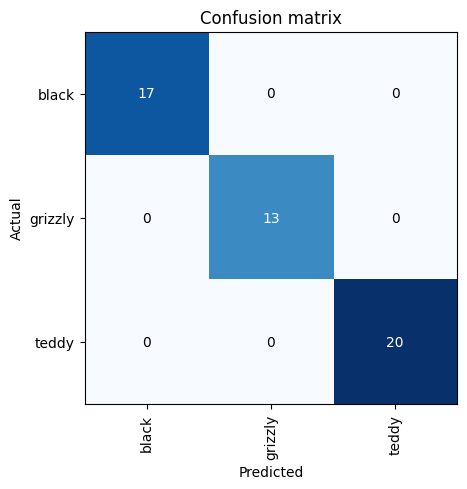

In [14]:
from fastai.vision.all import ClassificationInterpretation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represent all the black, grizzly, and teddy bears in our dataset, respectively. The columns represent the images which the model predicted as black, grizzly, and teddy bears, respectively. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly.

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. `plot_top_loss` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

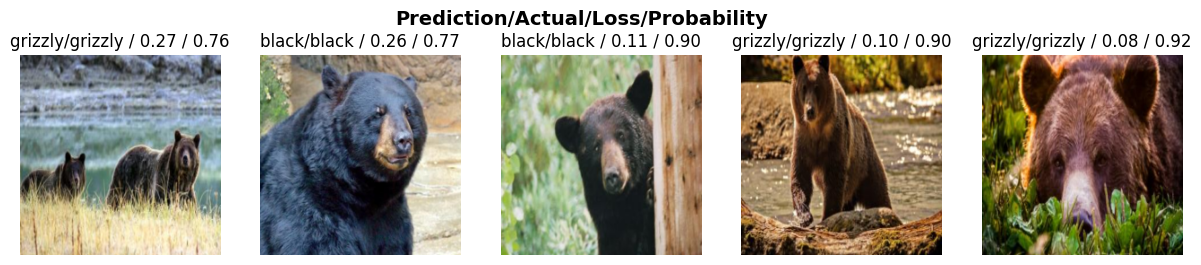

In [15]:
interp.plot_top_losses(5, nrows=1)

In our example we have all correct images, however you can see them sorted by loss value. May you can spot problems or sample with wrong labels, we should correct them!

The intuitive approach to doing data cleaning is to do it **before** you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, we normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

fastai includes a handy GUI for data cleaning called `ImageClassifierCleaner` that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [18]:
import fastbook
from fastbook import *
fastbook.setup_book()
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

You can navigate train and val and choose delete or change the labels. `ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you, so you should uncomment the cell below.

In [21]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

After you've cleaned your data, you can re-train you model with the same code used before1

In [ ]:
# data-loader
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
# fine-tune 
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)
# evaluation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

How to further improve?
- You can explore different pre-trained model, herein we have used resnet18, but you could try other CNN from timm. Explore [this notebook](https://www.kaggle.com/code/jhoward/which-image-models-are-best) by Jeremy to understand which model could match you needs;
- More data!

## Turning Your Model into an Online Application

Now, we are going to run our model in a production environment in an online application. The fastbook presents a slightly different version from the video in the course. The latter one is based on this [online tutorial](https://www.tanishq.ai/blog/posts/2021-11-16-gradio-huggingface.html) about **Gradio + HuggingFace Spaces: A Tutorial**.

From the tutorial, 
> After you train a machine learning model, the next thing to do is showcase it to the world by making a demo. Currently, the easiest way to do so is with Gradio, hosting on HuggingFace Spaces. With the Gradio framework deployed on Spaces, it takes <10 minutes to deploy a model! Let’s see how we can easily deploy a model for the world to try out with these platforms!

Let's create a new space on HuggingFace, you can do it for free [here](https://huggingface.co/new-space) using Gradio! Spaces basically work with git, you can clone a space on your local machine and work on it.

Now you can copy the example minima project on you local machine and push it on the HuggingFace project as a remote GitHub repository! You should have something like that:

<div style="text-align:center">
<img src="./images/hf_minima.PNG" width="600" height="400">
</div>

HuggingFace is building a Gradio app for us and hosting it! Now we are going to host our model on this space!

### Saving a fastai trained model

In order to use our trained model on gradio, we have to save it locally. We can do it as done in this [Kaggle notebook](https://www.kaggle.com/code/jhoward/saving-a-basic-fastai-model) from Jeremy. This is going to save our learner in a serialized pickle object inside out minima project!

In [24]:
learn.export('./minima/model.pkl')

### Gradio interface

Let's create a gradio interface in this notebook!

Firstly, we need to define out prediction function.

In [25]:
labels = learn.dls.vocab
def predict(img):
    img = PILImage.create(img)
    pred,pred_idx,probs = learn.predict(img)
    return {labels[i]: float(probs[i]) for i in range(len(labels))}

In [28]:
predict(im)

{'black': 5.385812528402312e-06,
 'grizzly': 0.9999562501907349,
 'teddy': 3.834073504549451e-05}

In [30]:
import gradio as gr
demo = gr.Interface(fn=predict, inputs="image", outputs="label")
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


### Push it on HF Space!

You need to create an app.py file in your repository with our gradio script. Please, look at the [project minima](https://huggingface.co/spaces/fconti/minima) on HF to checkout how to do that!


## Go further Gradio

Gradio, as Streamlit, are good app to prototype webapp. But actually, you maybe want to customize the front-end.

For this, you can use the API make available in the HF spaces. You can [read the docs](https://jph00-testing.hf.space/api) to understand how to call the HF web-app inside a Java/Python program.
As the service is hosted by HF, you can build a FE app in html+javascript without the need to install python on the user PC!

## Homework

I chosed to developed a Christmans-themed classifier that answers to the age-old question in Italy: "Panettone or Pandoro?". I replicated the procedure od this [notebook here](https://huggingface.co/spaces/fconti/christmas_panvision/blob/main/christmas_panvision_train.ipynb). This is the (link) to my HF Space with my [final project](https://huggingface.co/spaces/fconti/christmas_panvision).